In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import matplotlib.patches as pltpat
import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

import windrose

In [132]:
data = xr.open_dataset('wave_dir2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
wave = data.variables['VHM0'][:]

data

<xarray.Dataset>
Dimensions:    (latitude: 47, time: 8760, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-04-10 00
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [133]:
data.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (latitude: 47, time: 8760, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date: 

In [21]:
# mp2 = Basemap(projection='merc',
#              llcrnrlon=lons.values[0],  
#              llcrnrlat=lats.values[0], 
#              urcrnrlon=lons.values[-1], 
#              urcrnrlat=lats.values[-1],  
#              resolution='f') # f

# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp2(lon, lat)
mp = Basemap(projection='merc',
             llcrnrlon=6.4166675, 
             llcrnrlat=40.604168,
             urcrnrlon=15.208334,  
             urcrnrlat=45.5625, 
             resolution='f')
             
lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

In [268]:
x_min, y_min = mp(lons.values[0], lats.values[0]) 
x_max, y_max = mp(lons.values[-1], lats.values[-1]) 

pointx, pointy = mp(9.46, 41.69) 

In [295]:
lons.values[39]
lats.values[33]

42.729168

<ipython-input-269-50f32a7d84e4>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, waveyear[0], cmap='jet')
<ipython-input-269-50f32a7d84e4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(axtik, fontsize=25)


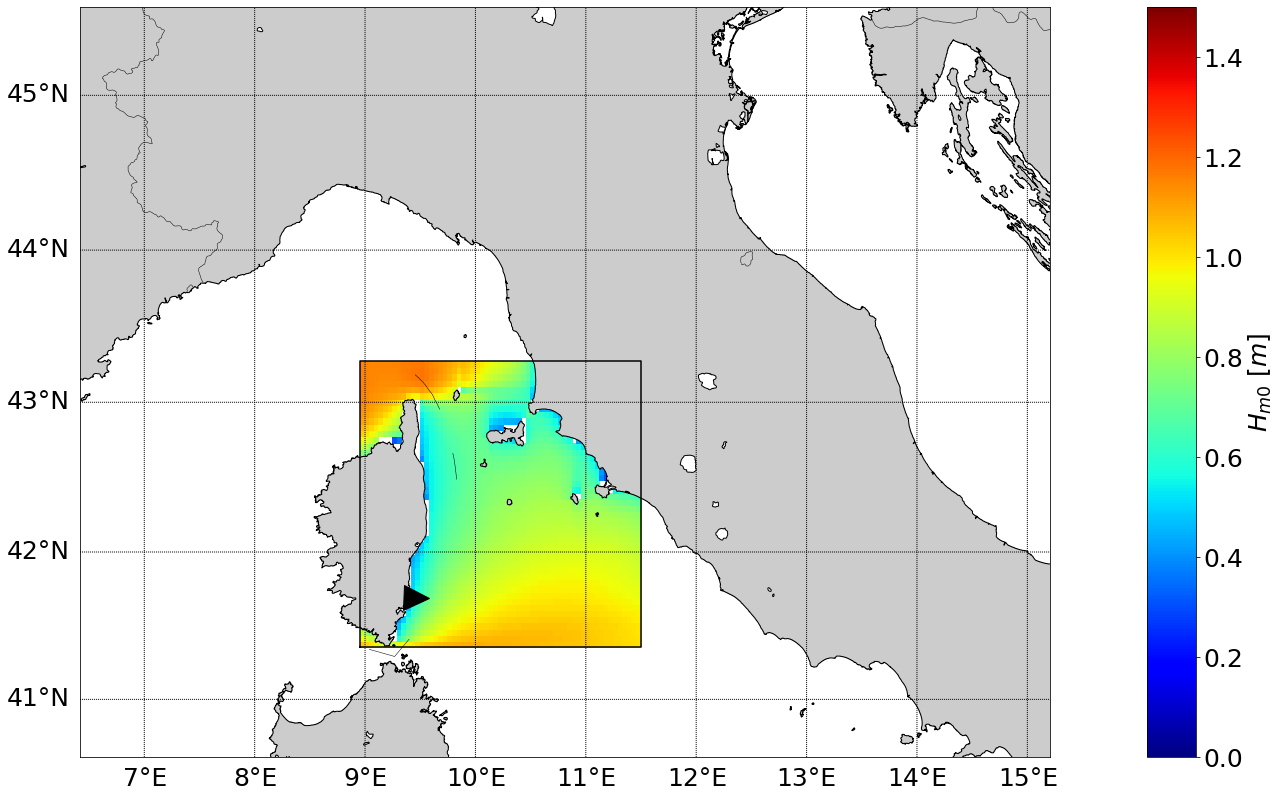

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
c_scheme = mp.pcolor(x, y, waveyear[0], cmap='jet')
mp.plot(pointx, pointy, ">k", markersize=25)
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

cbar = mp.colorbar(c_scheme, location='right', pad='10%')
mp.drawmeridians(np.arange(6,16,1.0),labels=[0,0,0,1], fontsize=25) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0], fontsize=25) #latitudes
axtik = cbar.ax.get_yticks().tolist()
for i in range(len(axtik)):
    axtik[i] = round(axtik[i],1)
cbar.set_label('$H_{m0}$ $[m]$', fontsize=25)
cbar.ax.set_yticklabels(axtik, fontsize=25)
plt.clim([0, 1.5])
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")

plt.show()

In [296]:
point = {'x': 10.58,#11.04,# 10.31,#9.46,#10.31,
         'y': 42.73}#42.52}#42.33}#41.69}#42.33}

data_sel = data.sel(latitude=point['y'], longitude=point['x'], method='nearest')
data_sel

waveloc = data_sel['VHM0'].round(2)
dirloc = data_sel['VMDR'].astype(int)

hs_min = 0.1
hs_max = 2.6
hs_step = 0.4

# Set the numbers of bins (limits) for hs.
bin_hs = np.arange(hs_min, hs_max, hs_step)

# Set numbers of bins for directions (directions “bundaries”) 
# used to compute the distribution by waves direction sector.
bin_dir = 24 # 360 degrees/24 = 15 degrees each

In [277]:
print(bin_hs)

[0.1 0.5 0.9 1.3 1.7 2.1 2.5]


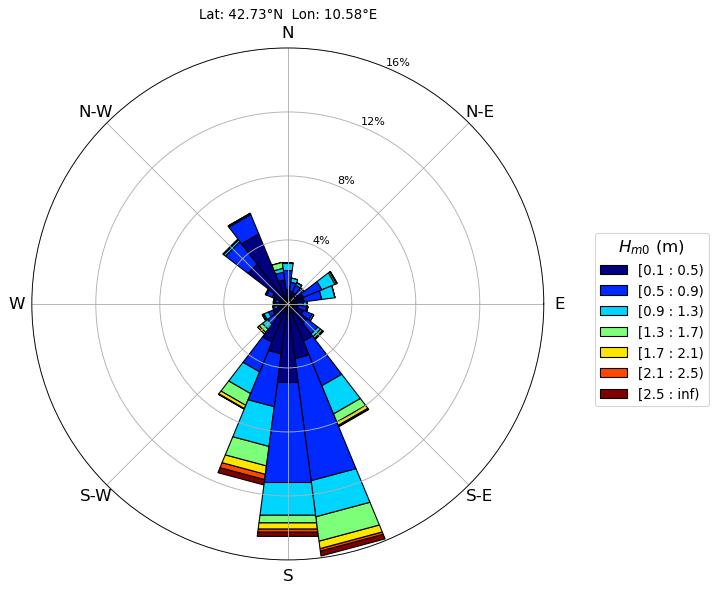

In [304]:
from matplotlib.text import Text
# def plot_windrose(ds, normed):
ds = data['VHM0']
normed = True
# var_title = ds.long_name
tempx = round(point['x'],2)
tempy = round(point['y'],2)
title = 'Lat: {y}°N  Lon: {x}°E'.format(y = point['y'], x = point['x'])
#     title = f'Latitude:{41.65}°N  Longitude:{9.46}°E'

ax = windrose.WindroseAxes.from_ax()
ax.bar(dirloc.data, waveloc.data, bins=bin_hs, nsector=bin_dir, normed=normed, opening=1, edgecolor='k')# edgecolor='k')

# ax.set_legend(title='$H_{m0}$ (m)', prop={'size': 'large'})
# ax.set_legend(title='$H_{m0}$ (m)', prop={"size":20}, loc=(1.1,0.2), markerscale=1)
plt.title(title)

ax.legend(title='$H_{m0}$ (m)', fontsize=12, loc=(1.1,0.3), title_fontsize=15)
# output file
#     output_file = os.path.join(out_path, var_title.replace(' ','_')) + ".png"

# save the output file
#     
#     ax.set_xticklabels(['N', 'NW',  'W', 'SW', 'S', 'SE','E', 'NE'])
ax.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'], fontsize=15)

ax.set_yticks(np.arange(0, 18, 4))
axtik = ax.get_yticks().tolist()
axlabels = []
temp = 0
for i in axtik:
    to_ins = Text(i,0,str(round(i,1))+"%")
    axlabels.append(to_ins)

# ax.set_yticks(axtik)
ax.set_yticklabels(axlabels,rotation=0, fontsize=10)

# don't forget to also change the labels
# ax.set_yticklabels(np.arange(0, 16, 3))
#     ax.set_theta_zero_location('N')
plt.savefig("waveroseend2.png", dpi=300, bbox_inches='tight')
plt.show()

plt.close()

table = ax._info['table']
# return table

In [210]:
# t_normed = plot_windrose(data['VHM0'], True)

In [129]:
# data['VHM0'].hist(figsize=(10,6))

In [98]:
t_normed.shape

(18, 24)

In [86]:
import pandas as pd
df = pd.DataFrame(t_normed)

In [94]:
df = pd.DataFrame({"Timestep": waveloc.time, "SWH": waveloc, "Direction": dirloc })
# pd.reset_option("display.max_rows","display.max_columns")
df

,Timestep,SWH,Direction
0,2021-01-01 00:00:00,0.98,188
1,2021-01-01 01:00:00,1.09,188
2,2021-01-01 02:00:00,1.20,188
3,2021-01-01 03:00:00,1.29,188
4,2021-01-01 04:00:00,1.35,188
...,...,...,...
8755,2021-12-31 19:00:00,0.42,341
8756,2021-12-31 20:00:00,0.44,338
8757,2021-12-31 21:00:00,0.32,335
8758,2021-12-31 22:00:00,0.36,334
